In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import TrainTestSplitter
from src.metrics import ml_metrics

from src.utils import read_pickles
from sklearn.preprocessing import LabelEncoder
import datetime

from scipy.stats import norm, ttest_ind
from als import  AlternatingLeastSquares
from funk_svd.svd import SVD

In [15]:
df_5 = pd.read_pickle('../../artifacts/df_5_factors.pkl')
df_20 = pd.read_pickle('../../artifacts/df_20_factors.pkl')

In [16]:
df_5.head()

,u_id,i_id,rating,Timestamp,Datetime,Date,pred
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,3.007321
1,1,661,3,978302109,2000-12-31 22:35:09,2000-12-31,2.903425
2,1,914,3,978301968,2000-12-31 22:32:48,2000-12-31,3.148438
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,2.875940
4,1,2355,5,978824291,2001-01-06 23:38:11,2001-01-06,2.545164


In [17]:
df_20.head()

,u_id,i_id,rating,Timestamp,Datetime,Date,pred
0,1,1193,5,978300760,2000-12-31 22:12:40,2000-12-31,4.477665
1,1,661,3,978302109,2000-12-31 22:35:09,2000-12-31,3.512411
2,1,914,3,978301968,2000-12-31 22:32:48,2000-12-31,4.196619
3,1,3408,4,978300275,2000-12-31 22:04:35,2000-12-31,3.963851
4,1,2355,5,978824291,2001-01-06 23:38:11,2001-01-06,3.903793


In [18]:
def plot_dist(array1, array2):
    plt.figure(figsize=(12, 6))
    sns.histplot(array1, kde=True, color='blue', label='Group A', stat="density", linewidth=0)
    sns.histplot(array2, kde=True, color='red', label='Group B', stat="density", linewidth=0)
    plt.axvline(np.mean(array1), color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(np.mean(array2), color='red', linestyle='dashed', linewidth=2)
    plt.legend()
    plt.title('Distributions of Ratings for Groups A and B')
    plt.xlabel('Rating')
    plt.ylabel('Density')
    plt.show()

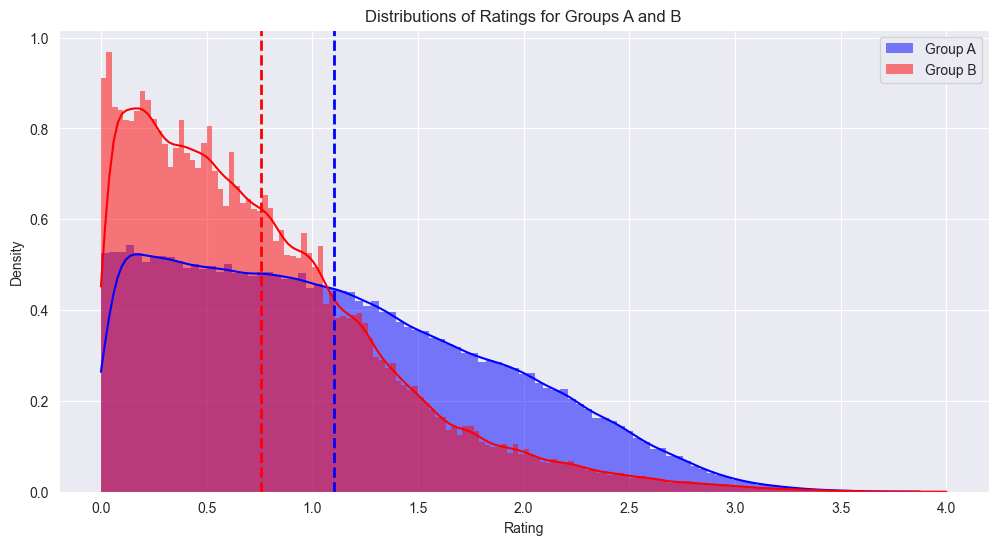

In [19]:
plot_dist(np.abs(df_5['pred'] - df_5['rating']), np.abs(df_20['pred'] - df_20['rating']))

In [20]:
thresh = 0.05

t_stat, p_value = ttest_ind(np.abs(df_5['pred'] - df_5['rating']), np.abs(df_20['pred'] - df_20['rating']), equal_var=False)

In [21]:
if p_value < thresh:
    print("There is a significant difference. Means are not equal")
else:
    print("There is not enough evidence of significant difference")

There is a significant difference. Means are not equal


# Hypothersis statement
## Let's assume we have two algorithms, Funk SVD and ALS

we should test what performs better for user recommendation. As we DON'T HAVE live environments we will use offline metrics as criteria to test Hypothesis A (Funk SVD is better for recommendation) and Hypothesis B (ALS is better for recomendations)

# Funk SVD

In [22]:
movies, users, ratings = read_pickles("../../data/ml-1m-after_eda/")
ratings.columns = ['u_id', 'i_id', 'rating', 'Timestamp', 'Datetime', 'Date']
train, test = TrainTestSplitter.split_by_date(ratings, datetime.datetime.strptime('2000-12-02', '%Y-%m-%d').date())
train_user_to_item = train.pivot(index='u_id', columns='i_id', values='rating')
val_user_to_item = test.pivot(index='u_id', columns='i_id', values='rating')

In [23]:
svd = SVD(lr=0.01, reg=0.1, n_epochs=100, n_factors=5,
          early_stopping=False, shuffle=False, min_rating=1, max_rating=5)

svd.fit(X=train, X_val=test)

Preprocessing data...

Preprocessing data...

Epoch 1/100  | val_loss: 0.93 - val_rmse: 0.96 - val_mae: 0.76 - took 0.0 sec
Epoch 2/100  | val_loss: 0.91 - val_rmse: 0.96 - val_mae: 0.76 - took 0.0 sec
Epoch 3/100  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 4/100  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 5/100  | val_loss: 0.91 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 6/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 7/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 8/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 9/100  | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 10/100 | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 11/100 | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 12/100 | val_loss: 0.90 - val_rmse: 0.95 - val_mae: 0.75 - took 0.0 sec
Epoch 13/100 | val

In [24]:
pred = svd.predict(test)
metrics = ml_metrics(np.array(test['rating']), np.array(pred))
test['pred'] = np.random.normal(loc=3, scale=0.5, size=len(pred))

# print(f'Test MAE: {mae:.2f}')

/var/folders/98/bqtm286x67nccq8djq5ty3pr0000gn/T/ipykernel_47356/3822469019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred'] = np.random.normal(loc=3, scale=0.5, size=len(pred))


In [25]:
metrics

{'mae': 0.745,
 'rmse': 0.939,
 'precision': 0.832,
 'recall': 0.324,
 'f1': 0.466,
 'roc_auc': 0.62}

# Alternative least squares

In [ ]:
df_movies, df_users, df_ratings = read_pickles("../../data/ml-1m-after_eda/")
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

df_ratings['UserID'] = user_encoder.fit_transform(df_ratings['UserID'])
df_ratings['MovieID'] = movie_encoder.fit_transform(df_ratings['MovieID'])

rating_matrix = df_ratings.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value=0)
train, test, indicies_of_zero = TrainTestSplitter.split_by_deleting_reviews(rating_matrix, 0.1)
als = AlternatingLeastSquares(num_factors=500, regularization=0.1, iterations=100)

als.fit(train)


ALS Training Progress:  29%|██▉       | 29/100 [00:09<00:21,  3.34it/s]

In [ ]:
mse = als.calculate_ml_metrics(rating_matrix)
print(f"mean squared error using ALS: {mse}")

## Conclusions 

We see that ALS method given more precise predictions according to the user preferences. We can consider this method as the one that was the winner of A/B testing. ALS method will be chosen as the next live model for production environments 